# Soils simulation benchmark

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.seterr(all="ignore")

from biom import load_table, Table
from src.evaluate import _edge_roc_curve
from matplotlib.ticker import MaxNLocator
from skbio.stats.composition import closure
%matplotlib inline

In [2]:
results_dir = '../../data/simulations/soil_benchmarking/'
microbes = load_table(os.path.join(results_dir, 'data/table.abs.microbes.0.biom'))
metabolites = load_table(os.path.join(results_dir, 'data/table.abs.metabolites.0.biom'))

rel_microbes_dense = pd.read_csv(os.path.join(results_dir, 'data/rel.microbes.0.tsv'), sep='\t', index_col=0)
rel_microbes_dense = Table(rel_microbes_dense.values,
                            rel_microbes_dense.index, rel_microbes_dense.columns)
rel_metabolites_dense = pd.read_csv(os.path.join(results_dir, 'data/rel.metabolites.0.tsv'), sep='\t', index_col=0)
rel_metabolites_dense = Table(rel_metabolites_dense.values,
                               rel_metabolites_dense.index, rel_metabolites_dense.columns)
rel_microbes_sparse = pd.read_csv(os.path.join(results_dir, 'data/rel.microbes.10.tsv'), sep='\t', index_col=0)
rel_microbes_sparse = Table(rel_microbes_sparse.values,
                            rel_microbes_sparse.index, rel_microbes_sparse.columns)
rel_metabolites_sparse = pd.read_csv(os.path.join(results_dir, 'data/rel.metabolites.10.tsv'), sep='\t', index_col=0)
rel_metabolites_sparse = Table(rel_metabolites_sparse.values,
                               rel_metabolites_sparse.index, rel_metabolites_sparse.columns)
mf = pd.read_csv(os.path.join(results_dir, 'data/metadata.tsv'), sep='\t', index_col=0)
mf.head(5)


,time,train_test
sample_name,,
3min_early,3min,train
9hr_early,9hr,train
18hr_early,18hr,train
42hr_early,42hr,train
49p5hr_early,49hr,train


## check rel abundance of m. vaginatus

In [3]:
microbes_df = microbes.to_dataframe().copy()
microbes_df = microbes_df.apply(closure)

microbes_df_stats = pd.concat([microbes_df.T[['rplo 1 (Cyanobacteria)']], mf], axis=1)
microbes_df_stats['stage'] = [x.split('_')[-1] for x in microbes_df_stats.index]
microbes_df_stats.drop(columns='train_test', inplace=True)
microbes_df_stats['rplo 1 (Cyanobacteria)'] = [100*np.round(x, 4) for x in microbes_df_stats['rplo 1 (Cyanobacteria)']]
microbes_df_stats = microbes_df_stats[['time','stage','rplo 1 (Cyanobacteria)']]
microbes_df_stats.rename(columns={'time':'Time', 'stage':'Biocrust Stage', 
                                  'rplo 1 (Cyanobacteria)': 'Abundance (%)'})

microbes_df_stats.to_csv('../../results/supp-table-3-mvaginatus-rel-abundance.csv')
microbes_df_stats

,time,stage,rplo 1 (Cyanobacteria)
3min_early,3min,early,20.17
3min_earlymid,3min,earlymid,22.48
3min_latemid,3min,latemid,9.68
3min_late,3min,late,25.19
9hr_early,9hr,early,9.50
9hr_earlymid,9hr,earlymid,7.19
9hr_latemid,9hr,latemid,9.16
18hr_early,18hr,early,14.16
18hr_earlymid,18hr,earlymid,4.89
18hr_latemid,18hr,latemid,5.46


In [4]:

def load_corr_tables(tool, abs_file, rel_file_dense, rel_file_sparse):
    
    microbe_ids = microbes.ids(axis='observation')
    metabolite_ids = metabolites.ids(axis='observation')
    results_dir = '../../data/simulations/soil_benchmarking/'
    abs_ranks = pd.read_csv(os.path.join(results_dir, 'abs/' + abs_file),
                            index_col=0)
    rel_ranks_dense = pd.read_csv(os.path.join(results_dir, 'rel/' + rel_file_dense),
                            index_col=0)
    rel_ranks_sparse = pd.read_csv(os.path.join(results_dir, 'rel/' + rel_file_sparse),
                                   index_col=0)
        
    # compare dense
    microbe_ids = list(set(abs_ranks.index) & set(rel_ranks_dense.index))
    metabolite_ids = list(set(abs_ranks.columns) & set(rel_ranks_dense.columns))
    abs_ranks_d = abs_ranks.loc[microbe_ids, metabolite_ids]
    rel_ranks_dense = rel_ranks_dense.loc[microbe_ids, metabolite_ids]
    # compare sparse
    microbe_ids = list(set(abs_ranks.index) & set(rel_ranks_sparse.index))
    metabolite_ids = list(set(abs_ranks.columns) & set(rel_ranks_sparse.columns))
    abs_ranks_s = abs_ranks.loc[microbe_ids, metabolite_ids]
    rel_ranks_sparse = rel_ranks_sparse.loc[microbe_ids, metabolite_ids]

    return abs_ranks, rel_ranks_dense, rel_ranks_sparse

fnames = [
    ['joint-rpca', 'rpca.csv', 'dense.rpca.csv', 'sparse.rpca.csv'],
    ['mmvec', 'mmvec.csv','dense.mmvec.csv','sparse.mmvec.csv'],
    ['SparCC', 'SparCC.csv','SparCC.0.csv', 'SparCC.10.csv'],
    ['SPIEC-EASI', 'SPIECEASI.csv', 'SPIECEASI.0.csv', 'SPIECEASI.10.csv'],
    ['pearson', 'prop_matrix_pearson.csv','prop_matrix_pearson.0.csv', 'prop_matrix_pearson.10.csv'],
    ['spearman', 'prop_matrix_spearman.csv', 'prop_matrix_spearman.0.csv', 'prop_matrix_spearman.10.csv'],
    ['phi', 'prop_matrix_PHI.csv', 'prop_matrix_PHI.0.csv', 'prop_matrix_PHI.10.csv'],
    ['rho', 'prop_matrix_RHO.csv', 'prop_matrix_RHO.0.csv', 'prop_matrix_RHO.10.csv'],
]


corr_tables = {}
for res in fnames:
    t, a, r, s = res
    tables_tmp = load_corr_tables(t, a, r, s)
    corr_tables[t] = tables_tmp
for v in corr_tables['joint-rpca']:
    v.index.name = None


# Precision-Recall curves

In [5]:
microcoleus_metabolites = ['(3-methyladenine)', '7-methyladenine', '4-guanidinobutanoate', 'uracil',
                           'xanthine', 'hypoxanthine', '(N6-acetyl-lysine)', 'cytosine',
                           'N-acetylornithine', 'N-acetylornithine', 'succinate',
                           'adenosine', 'guanine', 'adenine']
len(metabolites.ids('observation'))

85

In [6]:
density_cov_tables = {}

for i, density in enumerate(['original high density (microbiome 50% dense)',
                             'medium density (microbiome 10% dense)',
                             'low density (microbiome <1% dense)']):
    print(density)
    corr_tables_sorted = corr_tables['joint-rpca'][i].loc[['rplo 1 (Cyanobacteria)']].T.sort_values('rplo 1 (Cyanobacteria)', ascending=False)
    #remove self correlation
    corr_tables_sorted = corr_tables_sorted.drop('rplo 1 (Cyanobacteria)', axis=0)
    #remove microbes (keep only metabolites)
    corr_tables_sorted = corr_tables_sorted[corr_tables_sorted.index.isin(metabolites.ids('observation'))]
    corr_tables_sorted = corr_tables_sorted.reset_index(names=['Metabolite'])
    corr_tables_sorted = corr_tables_sorted.reset_index(names=['Ranking'])
    corr_tables_sorted['Ranking'] += 1
    corr_tables_sorted.rename(columns={'rplo 1 (Cyanobacteria)': 'M. Vaginatus Covariance'}, inplace=True)
    corr_metabs_of_interest = corr_tables_sorted[corr_tables_sorted['Metabolite'].isin(microcoleus_metabolites)]
    display(corr_metabs_of_interest)
    density_cov_tables[density] = corr_metabs_of_interest

    corr_feats_sub = corr_tables['joint-rpca'][i].loc[['rplo 1 (Cyanobacteria)']]
    #remove self correlation
    corr_feats_sub = corr_feats_sub.drop('rplo 1 (Cyanobacteria)', axis=1)
    print("Avg. covariance between M. Vaginatus and all other metabolites + microbes: {}".format(round(corr_feats_sub.mean(axis=1)[0], 5)))
    corr_feats_sub = corr_feats_sub[metabolites.ids('observation')]
    print("Avg. covariance between M. Vaginatus and all other metabolites: {}".format(round(corr_feats_sub.mean(axis=1)[0], 5)))
    print()

original high density (microbiome 50% dense)


,Ranking,Metabolite,M. Vaginatus Covariance
0,1,adenine,5.648718
1,2,(N6-acetyl-lysine),5.119565
2,3,4-guanidinobutanoate,4.797857
3,4,adenosine,4.142563
6,7,guanine,3.545064
7,8,cytosine,3.510269
16,17,uracil,2.165634
19,20,N-acetylornithine,1.731061
20,21,7-methyladenine,1.674761
22,23,(3-methyladenine),1.466123


Avg. covariance between M. Vaginatus and all other metabolites + microbes: -0.01014
Avg. covariance between M. Vaginatus and all other metabolites: 0.01283

medium density (microbiome 10% dense)


,Ranking,Metabolite,M. Vaginatus Covariance
0,1,adenine,0.406624
1,2,(N6-acetyl-lysine),0.365182
2,3,4-guanidinobutanoate,0.335393
3,4,adenosine,0.294940
6,7,cytosine,0.243281
7,8,guanine,0.239451
17,18,uracil,0.125318
19,20,N-acetylornithine,0.094299
20,21,7-methyladenine,0.082964
23,24,(3-methyladenine),0.068231


Avg. covariance between M. Vaginatus and all other metabolites + microbes: -0.00046
Avg. covariance between M. Vaginatus and all other metabolites: -0.00012

low density (microbiome <1% dense)


,Ranking,Metabolite,M. Vaginatus Covariance
0,1,adenine,0.032147
1,2,(N6-acetyl-lysine),0.028796
2,3,4-guanidinobutanoate,0.026261
3,4,adenosine,0.023954
6,7,cytosine,0.019825
7,8,guanine,0.018746
17,18,uracil,0.009857
19,20,N-acetylornithine,0.007452
23,24,(3-methyladenine),0.005033
26,27,7-methyladenine,0.004710


Avg. covariance between M. Vaginatus and all other metabolites + microbes: -0.00012
Avg. covariance between M. Vaginatus and all other metabolites: -3e-05



In [7]:
#save excel with each density as a different sheet
with pd.ExcelWriter('../../results/supp-table-4-biocrust-covariances.xlsx') as writer:
    for density, df in density_cov_tables.items():
        df.to_excel(writer, sheet_name=density, index=False)

/opt/anaconda3/envs/joint-rpca-benchmarking-flex/lib/python3.9/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [8]:
metabolites_ids_pr = metabolites.ids('observation')[metabolites.sum('observation') > 0]
select_microbes = ['rplo 1 (Cyanobacteria)', 'rplo 2 (Firmicutes)', 
                   'rplo 60 (Firmicutes)', 'rplo 7 (Actinobacteria)']
microcoleus_metabolites = ['(3-methyladenine)', '7-methyladenine', '4-guanidinobutanoate', 'uracil',
                           'xanthine', 'hypoxanthine', '(N6-acetyl-lysine)', 'cytosine',
                           'N-acetylornithine', 'N-acetylornithine', 'succinate', 
                           'adenosine', 'guanine', 'adenine']
microcoleus_metabolites = set(microcoleus_metabolites) & set(metabolites_ids_pr)
print(len(microcoleus_metabolites))

edges = pd.DataFrame(list(zip(['rplo 1 (Cyanobacteria)'] * len(microcoleus_metabolites), 
                     microcoleus_metabolites)), columns=['microbe', 'metabolite'])
edges['direction'] = 'R'
other_metabolites = list(set(metabolites_ids_pr) - set(microcoleus_metabolites))
print(len(other_metabolites))
other_edges = pd.DataFrame(other_metabolites, columns=['metabolite'])
other_edges['microbe'] = 'rplo 1 (Cyanobacteria)'
other_edges['direction'] = 0
edges = pd.concat((edges, other_edges), axis=0, sort=True)
edges = edges[['microbe', 'metabolite', 'direction']]

sensitivity = lambda x: x['TP'] / (x['TP'] + x['FN'])
specificity = lambda x: x['TN'] / (x['TN'] + x['FP'])
precision = lambda x: x['TP'] / (x['TP'] + x['FP'])
recall = lambda x: x['TP'] / (x['TP'] + x['FN'])
f1 = lambda x: 2 * x['precision'] * x['recall'] / (x['precision'] + x['recall'])

def roc_f(ranks, tool, edges_):
    r = ranks.T[['rplo 1 (Cyanobacteria)']].loc[metabolites_ids_pr].T
    #if tool == 'phi':
    #    r = 1 / r
        
    res = _edge_roc_curve(r, edges_, k_max=40)
    return res

def res_metrics(res):

    for df in res:
        df['TPR'] = df.apply(sensitivity, axis=1)
        df['TNR'] = df.apply(specificity, axis=1)
        df['precision'] = df.apply(precision, axis=1)
        df['recall'] = df.apply(recall, axis=1)
        df['f1_score'] = df.apply(f1, axis=1)
    
    return res
        
corr_tables['phi'] = [(1 / corr_tables['phi'][0]), 1/corr_tables['phi'][1], 1/corr_tables['phi'][2]]
corr_tables_res = {tool_:[res_metrics(roc_f(rank_i, tool_, edges))
                          for rank_i in ranks_]
                   for tool_, ranks_ in corr_tables.items()}
        

13
72


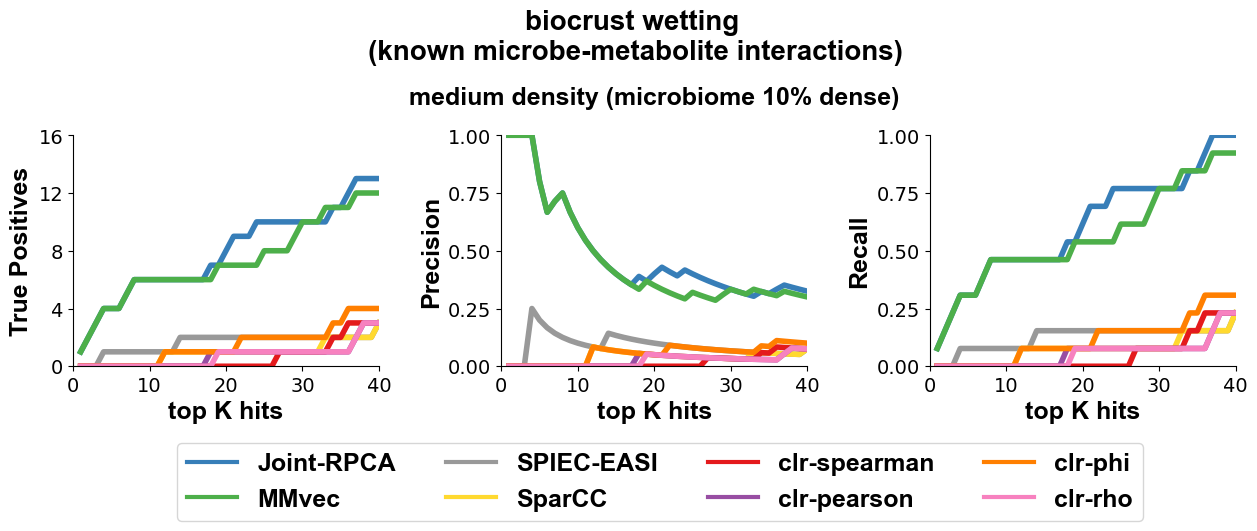

In [9]:
cmap_ = {'Joint-RPCA':'#377eb8', "MMvec":'#4daf4a',
         'spearman':'#e41a1c', 'pearson':'#984ea3',
         'phi':'#ff7f00', 'rho':'#f781bf',
         'SPIEC-EASI':'#999999', 'SparCC':'#ffd92f'}

fig, ax = plt.subplots(1, 3, figsize=(15, 3), sharex=True)
y_labels = {'TP':'True Positives', 'precision':'Precision', 'recall':'Recall'}
density_ = 'medium density (microbiome 10% dense)'
                             
def plot_stats(ax, attr='F score'):    
    ax.plot(corr_tables_res['joint-rpca'][1][0][attr], label='Joint-RPCA', lw=4, c=cmap_['Joint-RPCA'])
    ax.plot(corr_tables_res['mmvec'][1][0][attr], label='MMvec', lw=4, c=cmap_['MMvec'])
    ax.plot(corr_tables_res['SPIEC-EASI'][1][0][attr], label='SPIEC-EASI', lw=4, c=cmap_['SPIEC-EASI'])
    ax.plot(corr_tables_res['SparCC'][1][0][attr], label='SparCC', lw=4, c=cmap_['SparCC'])
    ax.plot(corr_tables_res['spearman'][1][0][attr], label='clr-spearman', lw=4, c=cmap_['spearman'])
    ax.plot(corr_tables_res['pearson'][1][0][attr], label='clr-pearson', lw=4, c=cmap_['pearson'])
    ax.plot(corr_tables_res['phi'][1][0][attr], label='clr-phi', lw=4, c=cmap_['phi'])
    ax.plot(corr_tables_res['rho'][1][0][attr], label='clr-rho', lw=4, c=cmap_['rho'])
    ax.set_ylabel(y_labels[attr], color='black', weight='bold', fontsize=18, fontname='Arial')
    ax.set_xlabel('top K hits', color='black', weight='bold', fontsize=18, fontname='Arial')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

plot_stats(ax[0], attr='TP')
plot_stats(ax[1], attr='precision')
plot_stats(ax[2], attr='recall')
ax[0].set_ylim(0, 16)
ax[1].set_ylim(0, 1)
ax[2].set_ylim(0, 1)

for ax_ in ax:
    ax_.spines['right'].set_visible(False)
    ax_.spines['left'].set_visible(True)
    ax_.spines['bottom'].set_visible(True)
    ax_.spines['top'].set_visible(False)
    ax_.set_xticks(np.arange(0, 40+1, 10))
    ax_.set_xlim(0, 40)

ax[1].set_title(density_, y=1.1, color='black', 
                weight='bold', fontsize=18, fontname='Arial')

plt.subplots_adjust(hspace=0.5, wspace=0.4)

handles, labels = ax[0].get_legend_handles_labels()
legend = ax[0].legend(handles[:8], labels[:8], loc='center left', 
                      bbox_to_anchor=(0.3, -0.5), ncol=4, 
                      fontsize=14, prop={'size':18, 'weight':'bold', 
                                         'family':'Arial'},)
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(3.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(3.0)
    
plt.suptitle('biocrust wetting \n(known microbe-metabolite interactions)',
             color='black', weight='bold', fontname='Arial',
             fontsize=20, y=1.3)

plt.savefig('../../results/supp-fig5.pdf', dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/supp-fig5.png', dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_54699/2755455770.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


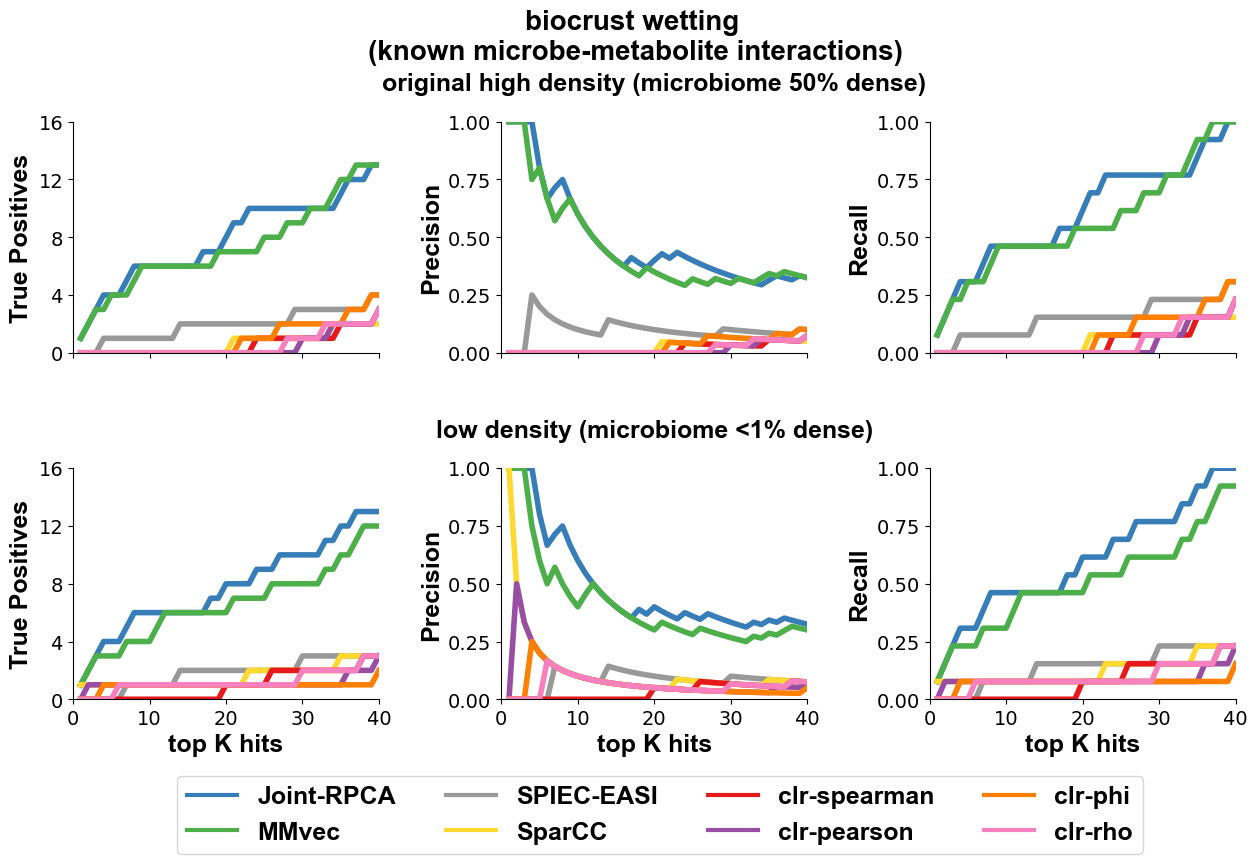

In [29]:
cmap_ = {'Joint-RPCA':'#377eb8', "MMvec":'#4daf4a',
         'spearman':'#e41a1c', 'pearson':'#984ea3',
         'phi':'#ff7f00', 'rho':'#f781bf',
         'SPIEC-EASI':'#999999', 'SparCC':'#ffd92f'}

fig, ax = plt.subplots(2, 3, figsize=(15, 7.5), sharex=True)

for ax_i, lolc_, density_ in zip([0, 1], [0, 2], 
                                 ['original high density (microbiome 50% dense)',
                                  'low density (microbiome <1% dense)']):

    def plot_stats(ax, attr='F score'):    
        ax.plot(corr_tables_res['joint-rpca'][lolc_][0][attr], label='Joint-RPCA', lw=4, c=cmap_['Joint-RPCA'])
        ax.plot(corr_tables_res['mmvec'][lolc_][0][attr], label='MMvec', lw=4, c=cmap_['MMvec'])
        ax.plot(corr_tables_res['SPIEC-EASI'][lolc_][0][attr], label='SPIEC-EASI', lw=4, c=cmap_['SPIEC-EASI'])
        ax.plot(corr_tables_res['SparCC'][lolc_][0][attr], label='SparCC', lw=4, c=cmap_['SparCC'])
        ax.plot(corr_tables_res['spearman'][lolc_][0][attr], label='clr-spearman', lw=4, c=cmap_['spearman'])
        ax.plot(corr_tables_res['pearson'][lolc_][0][attr], label='clr-pearson', lw=4, c=cmap_['pearson'])
        ax.plot(corr_tables_res['phi'][lolc_][0][attr], label='clr-phi', lw=4, c=cmap_['phi'])
        ax.plot(corr_tables_res['rho'][lolc_][0][attr], label='clr-rho', lw=4, c=cmap_['rho'])
        ax.set_ylabel(attr, color='black', weight='bold', fontsize=18, fontname='Arial')
        ax.tick_params(axis="x", labelsize=14)
        ax.tick_params(axis="y", labelsize=14)
        ax.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    plot_stats(ax[ax_i][0], attr='TP')
    plot_stats(ax[ax_i][1], attr='precision')
    plot_stats(ax[ax_i][2], attr='recall')
    ax[ax_i][0].set_ylim(0, 16)
    ax[ax_i][1].set_ylim(0, 1)
    ax[ax_i][2].set_ylim(0, 1)

    ax[ax_i][0].set_ylabel('True Positives', fontsize=18, weight='bold', fontname='Arial')
    ax[ax_i][1].set_ylabel('Precision', fontsize=18, weight='bold', fontname='Arial')
    ax[ax_i][2].set_ylabel('Recall', fontsize=18, weight='bold', fontname='Arial')
    for ax_ in ax[ax_i]:
        ax_.spines['right'].set_visible(False)
        ax_.spines['left'].set_visible(True)
        ax_.spines['bottom'].set_visible(True)
        ax_.spines['top'].set_visible(False)
        ax_.set_xticks(np.arange(0, 40+1, 10))
        ax_.set_xlim(0, 40)

    ax[ax_i][1].set_title(density_, y=1.1, color='black',
                          weight='bold', fontsize=18, fontname='Arial')
    
plt.subplots_adjust(hspace=0.5, wspace=0.4)

for i_ in range(3):
    ax[ax_i][i_].set_xlabel('top K hits', color='black', weight='bold', fontsize=18, fontname='Arial')

handles, labels = ax[ax_i][0].get_legend_handles_labels()
legend = ax[ax_i][0].legend(handles[:8], labels[:8], loc='center left', 
                            bbox_to_anchor=(0.3, -0.5), ncol=4, 
                            fontsize=14, prop={'size':18, 'weight':'bold', 
                                         'family':'Arial'},)
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(3.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(3.0)

plt.tight_layout()
    
plt.suptitle('biocrust wetting \n(known microbe-metabolite interactions)',
             color='black', weight='bold', fontname='Arial',
             fontsize=20, y=1.03)

plt.savefig('../../results/figure-3A-B.pdf', dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/figure-3A-B.png', dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()